In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime


from ngram import *
from baselines import *
from error_analysis import *
pd.options.mode.chained_assignment = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.43 ms


### Load Annotated Data

In [6]:
task = 'recipient'
xtype = 'comments'
ytype = 'plurality'
n_classes = 2

time: 1.17 ms


In [11]:
data = load_comments_and_labels(task)

time: 1min 59s


In [12]:
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 24.5 ms


### Hyper-Parameter tuning

In [13]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

time: 1.54 ms


In [22]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'vect__max_features': 50000, 'vect__ngram_range': (1, 5)} 0.974594083058


Grid scores:
0.95233 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 500, 'vect__ngram_range': (1, 5)}
0.96479 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 5000, 'vect__ngram_range': (1, 5)}
0.96840 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 10000, 'vect__ngram_range': (1, 5)}
0.97459 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 50000, 'vect__ngram_range': (1, 5)}
0.97133 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': None, 'vect__ngram_range': (1, 5)}
time: 3min 24s


### Eval Best Pipeline

In [25]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 50000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0,  solver = 'sag')),
])

time: 5.52 ms


In [26]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 4min 19s


In [27]:
roc_df

,random,blocked,both
user,0.992995,0.953369,0.964760
article,0.960139,0.966693,0.973540
both,0.978529,0.963249,0.972597


time: 8.73 ms


In [28]:
spearman_df

,random,blocked,both
user,0.188814,0.657504,0.605796
article,0.149509,0.431957,0.356463
both,0.189726,0.621921,0.548869


time: 4.81 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [30]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.990
	Spearman: 0.119

Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.993
	Spearman: 0.162
time: 1min 51s


#### Article

In [31]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.912
	Spearman: 0.131

Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.986
	Spearman: 0.173
time: 1min 54s


/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [32]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.993
	Spearman: 0.162

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.993
	Spearman: 0.189
time: 3min 37s


#### Article

In [33]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.986
	Spearman: 0.173

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.960
	Spearman: 0.150
time: 3min 56s


### Check Calibration

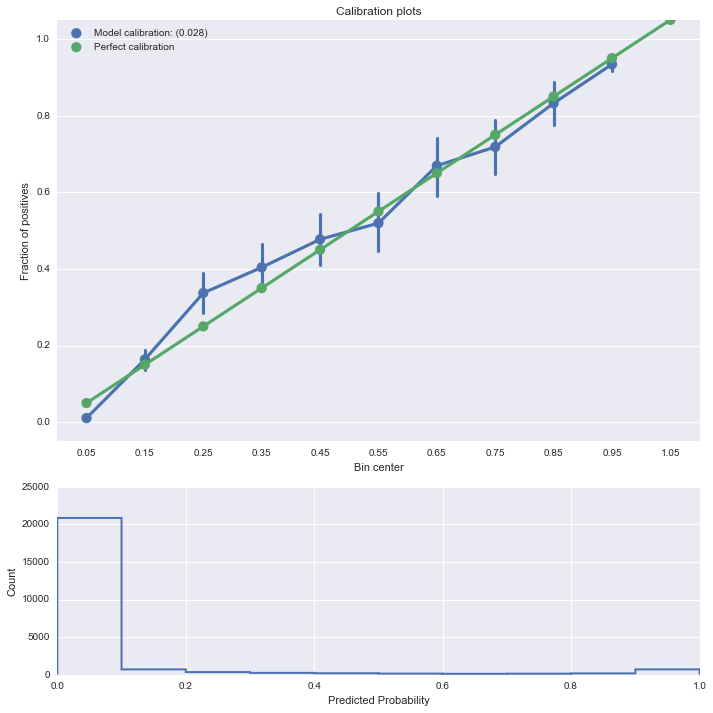

time: 42.9 s


In [34]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [35]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  1


OVER

COMMENT:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 She is a Motherfucker I will block you Motherfucker, Shit, bitch, punch, kill, swear, do nudity, so shut up, frickin around give you drugs, call you names like shit, fuck, bum, poo, damn! so fucker, you will be blocked and dead you shit and fuck, and I will do the rude finger sign. You fucker get bad new messages bum, oh shit.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
Fuck, Shit, Damn, Cock, Pissant, Motherfucker, and horse dick.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
Mark asten is a pussy pussy pussy pussy pussy pussy pussy loser loser loser fucker fucker fucker hooker hooker hooker son of a bitch son of a bitch son of a bitchWelcome
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
Anyone else glad that this stupid fucker offed himself?I sure am. Hey Britbarb, fuck

### Learning Curves!
How does adding more training data improve performance?

In [36]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 849 µs


### Model Understanding

In [37]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  1
STRONG POS: 
['ur mo' 'itch' 'sex' ' lia' ' jerk' ' fool' 'dumb' 'sh' 'ss' 'your' 'cunt'
 ' dumb' 'suck' 'o f' 'ck ' 'tup' ' fa' 'f*' ' hell' 'die ' ' fu' ' idi'
 'hut ' 'shut ' ' idio' 'gay' ' coc' 'stup' ' dick' 'tupi' 'stupi' 'pid'
 'tard' 'k off' 'e an ' ' cock' ' f*' ' f' '!' 'fool' ' die ' ' bitc'
 'upid' 'tupid' 'ur ' 'dio' 'oro' 'uk' 'go ' 'uck ' 'ole' '*' ' fuck'
 'e a ' ' gay' 'shit' 'you ' 'hole' 're a' ' ass ' 'idiot' 'ou ' 'bitch'
 'idio' 'dick' 'diot' 'die' 'fag' ' ass' 'bitc' 'iot' 'oron' 'idi' ' ur'
 'ck y' 'fu' 'are a' 'ck yo' ' yo' 'moro' ' you' 'ass' ' die' ' fag' ' fuc'
 ' ur ' 'moron' ' moro' ' y' 'uc' 're a ' 'ck' 'fuck' 'uck y' 'fuc' 'uck'
 'u ' ' u ' 'yo' 'you']
STRONG NEG: 
[' ' 'is a' '"' 'ank ' 'nk y' 'nk yo' 'hank ' ')' 'e' 'is ' ' "' 's a f'
 'thank' 'hank' 'ank y' ' he ' 's,' 'v' ' is a' 'sucks' '?' '\ni' 'his a'
 'm a' 's, ' 'they' 'op i' 'itch ' ' at ' 's a' 'is a ' 'ank' 'u fo' 'k on'
 's a ' ') ' "'re g" 'p i' '\ni ' 'ion' 'they ' '. ' 'u f

### Final Model

In [38]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 6min 40s
